# Data Collection
Load in libraries and datasets. The datasets come from Kaggle, internet sources, and a basketball reference scrape.

In [1]:
# read in libraries
import pandas as pd
import numpy as np
import pickle
pd.options.mode.chained_assignment = None 
pd.errors.DtypeWarning = None

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from urllib.request import urlopen
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Data Preparation
Merge date to the individual games dataset (one row for every player in every game) and use month and date to label each row with a season. The convention used is the first year in the season is the name of the season (i.e. 2015-2016 is the 2015 season). Then, filter for the relevant time periods, which are the months September through January for the 2012 - 2020 seasons. The 2020 NBA Championship games must then be removed because they took place in September and Ocotber due to postponements caused by COVID-19. There is also an issue with the 2020 data being duplicated so duplicates are removed.

In [3]:
# read in datasets

# kaggle datasets
games = pd.read_csv('data/games.csv') 
games_details = pd.read_csv('data/games_details.csv')
players = pd.read_csv('data/players.csv')
ranking = pd.read_csv('data/ranking.csv')
teams = pd.read_csv('data/teams.csv')

# datasets created from internet
jersey = pd.read_csv('data/jersey2.csv')
twok = pd.read_csv('data/2kRank.csv')
pacedata = {'season':[2012,2013,2014,2015,2016,2017,2018,2019,2020],
           'pace':[92.0,93.9,93.9,95.8,96.4,97.3,100.0,100.3,99.2]}
pace = pd.DataFrame(pacedata)

# load in scraped all star info
# get this from ASG Scrape
all_star_appearances = pickle.load(open('data/all_star_appearances.pickle', 'rb'))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# join date to individual games stats dataset
games_details2 = pd.merge(games_details, games[['GAME_DATE_EST', 'GAME_ID']], on = 'GAME_ID', how = 'left')

# extract year and month for every row
games_details2['year'] =  pd.to_numeric(games_details2['GAME_DATE_EST'].apply(lambda x: x.split('-')[0]))
games_details2['month'] =  pd.to_numeric(games_details2['GAME_DATE_EST'].apply(lambda x: x.split('-')[1]))

# label each row with season based on year and month
games_details2['season'] = games_details2[['year','month']].apply(lambda x: x['year']-1 if (x['month']==1) else x['year'], axis=1)

# keep only game info for September through January in the 2012-2020 seasons
games_details2 = games_details2[games_details2['month'].isin([9,10,11,12,1])]
games_details3 = games_details2[(games_details2['season']<2021) & (games_details2['season']>2011)]

# get rid of 2020 finals
games_details3 = games_details3[~((games_details3['season']==2020) & (games_details3['month'].isin([9,10])))]

# drop duplicates
games_details3 = games_details3.drop_duplicates(subset=['GAME_ID','PLAYER_ID'])

Prepares the individual games dataset to be summarized by player and season. It does this by getting rid of rows where the players did not play, getting rid of one erroneous row, extracting the number of minutes they played, and adding a helper column to indicate the player did play in the game.

In [5]:
# get rid of rows with comments (means they did not play)
games_details3 = games_details3[games_details3['COMMENT'].isnull()]

# get rid of one erroneous row
games_details3 = games_details3[games_details3['PTS'].notnull()]

# extract number of minutes played
games_details3['minutes'] =  pd.to_numeric(games_details3['MIN'].apply(lambda x: x.split(':')[0]))

# add a column to indicate they played in that game (useful for aggregation in next step)
games_details3['GP'] = 1

Finds the summary statistics by player and season for all the basic stats collected using groupby. This dataset forms the basis for the main dataset going forward.

In [6]:
# uses groupby to summarize by player and season
grouped = games_details3.groupby(['PLAYER_ID','season']).apply(lambda s: pd.Series({ 
    "PLAYER_NAME": s["PLAYER_NAME"].mode()[0],
    "TEAM_ABBREVIATION": s["TEAM_ABBREVIATION"].mode()[0],
    "TEAM_ID": s["TEAM_ID"].mode()[0],
    "GP": s["GP"].sum(),
    "Minutes": s["minutes"].mean(),
    "FGM": s["FGM"].mean(),
    "FGA": s["FGA"].mean(),
    "FG3M": s["FG3M"].mean(),
    "FG3A": s["FG3A"].mean(),
    "FTM": s["FTM"].mean(),
    "FTA": s["FTA"].mean(),
    "OREB": s["OREB"].mean(),
    "DREB": s["DREB"].mean(),
    "AST": s["AST"].mean(),
    "STL": s["STL"].mean(),
    "BLK": s["BLK"].mean(),
    "TO": s["TO"].mean(), 
    "PF": s["PF"].mean(),
    "PTS": s["PTS"].mean(),
    "PLUS_MINUS": s["PLUS_MINUS"].mean(),
    "Starting_Position": s["START_POSITION"].mode(),
})).reset_index()

Fix Starting_Position column so that the most common starting position for each player is displayed correctly and those with no information are labeled with "None".

In [7]:
# Fix Starting_Position column
grouped['Starting_Position'] = grouped['Starting_Position'].apply(lambda x: "None" if len(x)==0 else x[0])

Adjust each season for pace by merging the pace data and dividing the relevant columns by the pace/100.

In [8]:
# merge pace data
grouped = pd.merge(grouped, pace, on = ['season'], how = 'left')

# divide pace data by 100
grouped['pace'] = grouped['pace']/100

# divide relevant statistics by pace/100
grouped[['FGM','FGA','FG3M','FG3A','FTM','FTA','OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']] = grouped[['FGM','FGA','FG3M','FG3A','FTM','FTA','OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']].div(grouped.pace, axis=0)

Calculate Advanced Metrics PER and True Shooting Percentage.

In [9]:
# PER
grouped['PER'] = (grouped['FGM']*85.910 + grouped['STL']*53.897 + 
grouped['FG3M']*51.757 + grouped['FTM']*46.845 + grouped['BLK']*39.190
+ grouped['OREB']*39.190+ grouped['AST']*34.677 + grouped['DREB']*14.707
- grouped['PF']*17.174 - (grouped['FTA']-grouped['FTM'])*20.091 - (grouped['FGA']-grouped['FGM'])*39.190
- grouped['TO']*53.897)*(1/grouped['Minutes'])

# True Shooting Percentage
grouped['TSP'] = grouped['PTS']/(2*(grouped['FGA']+.44*grouped['FTA']))

Add each player's team win percentage and team conference for each season as of January 20. This is done first by keeping only the team ranking data as of January 20 for each season and adjusting the season ID to match the season. Then, this data is merged with the main data.

In [10]:
# keep only January 20 data
ranking2 = ranking[(ranking['STANDINGSDATE'].apply(lambda x: x.split('-')[1])=='01') & (ranking['STANDINGSDATE'].apply(lambda x: x.split('-')[2])=='20')]

# get season from the year
ranking2['season'] = ranking2['SEASON_ID']-20000
grouped = pd.merge(grouped, ranking2[['TEAM_ID', 'season','CONFERENCE','W_PCT']], on = ['TEAM_ID','season'], how = 'left')

Add if a player's jersey was in the top 15 of best sellers the previous year by merging with jersey data.

In [11]:
# merge jersey data
grouped = pd.merge(grouped, jersey, on = ['season','PLAYER_ID'], how = 'left')

Add the players' 2KRank for that season (released before the year starts).

In [12]:
# merge 2k data
grouped = pd.merge(grouped, twok[['PLAYER_ID','season','2KRank']],on=['PLAYER_ID','season'],how='left')

Adds All Star information for each player/season. Specifically, it adds wether a player was an All Star the previous year, the total amount of prior All Star selections a player had, and if a player was selected as an All Star that season (this is the target).

In [13]:
# function that defines if a player was an All star the previous year
def was_AS_last_year(row):
    if row['season'] == 1999:
        return 1 if 1998 in all_star_appearances[row['PLAYER_NAME']] else 0
    return 1 if row['season'] in all_star_appearances[row['PLAYER_NAME']] else 0

# adds if a player was an ALl star the previous year
grouped['LastASG?'] = grouped[['PLAYER_NAME', 'season']].apply(was_AS_last_year, axis=1)

# adds the total amount of prior selections a player had as of that year (not including that year)
grouped['PriorASG'] = grouped[['PLAYER_NAME', 'season']].apply(lambda row : sum(y<=row['season'] for y in all_star_appearances[row['PLAYER_NAME']]), axis=1)

# adds wether a player was selected as an all star that year
grouped['Selected?'] = grouped[['PLAYER_NAME', 'season']].apply(lambda row : 1 if row['season']+1 in all_star_appearances[row['PLAYER_NAME']] else 0, axis=1)


Adjusts for variability in games played up to that point in the season (especially relevant in 2020 season) by calculating the percentage of his team's games a player participated in.

In [14]:
# get total games played by each team up to that point in each season
game_count1 = games_details3.groupby(['season','GAME_ID','TEAM_ID']).GP.mean().reset_index()
game_count2 = game_count1.groupby(['season','TEAM_ID']).GP.sum().reset_index()

# merges Games Played rate with main dataset
grouped = pd.merge(grouped,game_count2,on=['season','TEAM_ID'],how='left')

# calculates percentage games played
grouped['GP_Per'] = grouped['GP_x'] / grouped['GP_y']

Null data is dealt with next, setting missing stats values to zero and giving unranked players a very low rank.

In [15]:
#fill null values
grouped['PLUS_MINUS'] = grouped['PLUS_MINUS'].fillna(0)
grouped['TSP'] = grouped['TSP'].fillna(0)
grouped['PER'] = grouped['PER'].fillna(0)
grouped['2KRank'] = grouped['2KRank'].fillna(500)

In [16]:
grouped.isnull().sum(axis = 0)


PLAYER_ID            0
season               0
PLAYER_NAME          0
TEAM_ABBREVIATION    0
TEAM_ID              0
GP_x                 0
Minutes              0
FGM                  0
FGA                  0
FG3M                 0
FG3A                 0
FTM                  0
FTA                  0
OREB                 0
DREB                 0
AST                  0
STL                  0
BLK                  0
TO                   0
PF                   0
PTS                  0
PLUS_MINUS           0
Starting_Position    0
pace                 0
PER                  0
TSP                  0
CONFERENCE           0
W_PCT                0
Jersey               0
2KRank               0
LastASG?             0
PriorASG             0
Selected?            0
GP_y                 0
GP_Per               0
dtype: int64

In the 2018 season All Star game, Dirk Nowitzki and Dwyane Wade were added as special additions to honor their legacy. They are removed from the dataset to not skew the data.

In [17]:
grouped.loc[(grouped['PLAYER_NAME']=='Dwyane Wade') & (grouped['season']==2018),'Selected?'] = 0
grouped.loc[(grouped['PLAYER_NAME']=='Dirk Nowitzki') & (grouped['season']==2018),'Selected?'] = 0

In [18]:
grouped

PLAYER_ID  season        PLAYER_NAME TEAM_ABBREVIATION     TEAM_ID  \
0            255    2012         Grant Hill               LAC  1610612746   
1            467    2012         Jason Kidd               NYK  1610612752   
2            703    2012        Kurt Thomas               NYK  1610612752   
3            708    2012      Kevin Garnett               BOS  1610612738   
4            708    2013      Kevin Garnett               BKN  1610612751   
...          ...     ...                ...               ...         ...   
5011     1630270    2020       Xavier Sneed               CHA  1610612766   
5012     1630271    2020     Brodric Thomas               HOU  1610612745   
5013     1630273    2020  Freddie Gillespie               DAL  1610612742   
5014     1630278    2020         Ade Murkey               MIN  1610612750   
5015  1962937827    2017          Matt Matt               SAC  1610612758   

      GP_x    Minutes       FGM        FGA      FG3M  ...       TSP  \
0       12  15.500000  1.992754   4.800725  0.090580  ...  0.459619   
1       43  27.674419  2.679474   6.597573  1.971689  ...  0.582444   
2       33  10.121212  1.119895   2.272727  0.000000  ...  0.495182   
3       49  28.959184  6.499556  12.843833  0.000000  ...  0.546139   
4       43  20.372093  3.071055   7.306140  0.000000  ...  0.449756   
...    ...        ...       ...        ...       ...  ...       ...   
5011     3   5.666667  0.672043   1.680108  0.672043  ...  0.600000   
5012     7   6.857143  0.720046   2.448157  0.288018  ...  0.438596   
5013     1   5.000000  1.008065   2.016129  0.000000  ...  0.500000   
5014     1   3.000000  0.000000   1.008065  0.000000  ...  0.000000   
5015     1   0.000000  0.000000   0.000000  0.000000  ...  0.000000   

      CONFERENCE  W_PCT  Jersey  2KRank  LastASG?  PriorASG  Selected?  GP_y  \
0           West  0.780       0    88.0         0         7          0    55   
1           East  0.658       0    54.0         0        10          0    49   
2           East  0.658       0   299.0         0         0          0    49   
3           East  0.500       0    28.0         0        14          1    51   
4           East  0.436       1    29.0         1        15          0    51   
...          ...    ...     ...     ...       ...       ...        ...   ...   
5011        East  0.429       0   500.0         0         0          0    24   
5012        West  0.308       0   500.0         0         0          0    22   
5013        West  0.500       0   500.0         0         0          0    23   
5014        West  0.231       0   500.0         0         0          0    22   
5015        West  0.289       0   500.0         0         0          0    56   

        GP_Per  
0     0.218182  
1     0.877551  
2     0.673469  
3     0.960784  
4     0.843137  
...        ...  
5011  0.125000  
5012  0.318182  
5013  0.043478  
5014  0.045455  
5015  0.017857  

[5016 rows x 35 columns]

### EDA

All Star Participants are picked on a variety of factors, including popular vote, media representation, and peer opinions. A large assumption we made in our project was that these popular or public opinions correlated highly with player statistics. We chose to only consider player statistics in our analysis, because these statistics tend to be highly regarded by the community, and are a good representation of how well a player does, in certain respects. 

We also used popularity data like Jersey sales to further inform our analysis.

Our data set includes the following columns:

In [19]:
grouped.columns


Index(['PLAYER_ID', 'season', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_ID',
       'GP_x', 'Minutes', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS',
       'Starting_Position', 'pace', 'PER', 'TSP', 'CONFERENCE', 'W_PCT',
       'Jersey', '2KRank', 'LastASG?', 'PriorASG', 'Selected?', 'GP_y',
       'GP_Per'],
      dtype='object')

In [20]:
# random eda

#grouped[(grouped['Selected?'] == 1) & (grouped['season'] == 2018)]
#grouped[grouped['PLAYER_NAME']=='Klay Thompson']
#grouped[grouped['PTS']>20].sort_values(by=['W_PCT'],ascending=False).head(10)
grouped['LastASG?']

0       0
1       0
2       0
3       0
4       1
       ..
5011    0
5012    0
5013    0
5014    0
5015    0
Name: LastASG?, Length: 5016, dtype: int64

The stats are computed as average per game, unless otherwise noted.
Here is a table with the column definitions

| Column/Variable Name | Definition |
|----------------------|----------- |
|`PLAYER_ID`| Unique identifier for the player |
|`season`| Season or year of the data |
|`PLAYER_NAME` | Name of the player |
|`TEAM_ABBREVIATION`| The team the player is playing for|
|`TEAM_ID`| Unique identifier for the player|
|`Minutes` | Number of minutes the player was in the game|
|`FGM` | Field Goals made (2-pointers and 3-pointers)|
|`FGA` | Field Goals attempted (2-pointers and 3-pointers)|
|`FG3M` | 3-pointers made |
|`FG3A` | 3-pointers atempted |
|`FTM` | Free Throws made |
|`FTA`| Free Throws attempted |
|`OREB`| The number of rebounds a player or team has collected while they were on offense |
|` DREB`| The number of rebounds a player or team has collected while they were on defense |
|`AST`| The number of assists made |
|`STL`| The number of steals made while on defense |
|`BLK` | The number of successful blocks made while on defense |
|`TO` | The number of turnovers |
|`PF` | Number of Personal fouls |
|`PTS` | Number of Points the player scored |
|`PLUS_MINUS`| point differential while player was in game |
|`Starting_Position`| The position the player most often started in|
|`pace` | The number of possessions per 48 minutes for a player|
|`PER` | An advanced metric used to rank players |
|`TSP` | True Shooting percentage |
|`CONFERENCE` | Which conference the player is in |
|`W_PCT` | *blank*|
|`Jersey` | Boolean to indicate whether the players jersey was in the top 15 in sales |
|`2KRank` | The overall 2K rank of the player before the season started |
|`LastASG?` | Boolean of whether the player participated in the season prior's All Star game |
|`PriorASG?` | Boolean of whether the player has participated in an All Star game prior to the current season |
|`Selected?`| Whether the player was selected for the current year's All Star Game |
|`GP_Per` | Percentage of games played in the season |


In [21]:
df = grouped[['PLAYER_ID', 'season', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_ID',
       'GP_x', 'Minutes', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'PER', 'TSP',
       'W_PCT', 'Jersey', '2KRank', 'LastASG?', 'PriorASG', 'Selected?', 'Starting_Position',
       'pace', 'CONFERENCE', 'GP_y', 'GP_Per']]

Let's take a look at some of the stats, and how they are spread:

In [22]:
# Which seasons we are looking at
grouped['season'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [23]:
stats = grouped.drop(['PLAYER_ID', 'TEAM_ID', 'GP_x', 'PLUS_MINUS', 'Jersey', 'GP_y', 'GP_Per'], 1)
stats

season        PLAYER_NAME TEAM_ABBREVIATION    Minutes       FGM  \
0       2012         Grant Hill               LAC  15.500000  1.992754   
1       2012         Jason Kidd               NYK  27.674419  2.679474   
2       2012        Kurt Thomas               NYK  10.121212  1.119895   
3       2012      Kevin Garnett               BOS  28.959184  6.499556   
4       2013      Kevin Garnett               BKN  20.372093  3.071055   
...      ...                ...               ...        ...       ...   
5011    2020       Xavier Sneed               CHA   5.666667  0.672043   
5012    2020     Brodric Thomas               HOU   6.857143  0.720046   
5013    2020  Freddie Gillespie               DAL   5.000000  1.008065   
5014    2020         Ade Murkey               MIN   3.000000  0.000000   
5015    2017          Matt Matt               SAC   0.000000  0.000000   

            FGA      FG3M      FG3A       FTM       FTA  ...  \
0      4.800725  0.090580  0.452899  0.996377  1.630435  ...   
1      6.597573  1.971689  5.030334  0.834176  0.935288  ...   
2      2.272727  0.000000  0.000000  0.197628  0.428195  ...   
3     12.843833  0.000000  0.221828  2.639752  3.349601  ...   
4      7.306140  0.000000  0.074300  0.792530  0.916363  ...   
...         ...       ...       ...       ...       ...  ...   
5011   1.680108  0.672043  1.680108  0.000000  0.000000  ...   
5012   2.448157  0.288018  1.440092  0.864055  1.152074  ...   
5013   2.016129  0.000000  1.008065  0.000000  0.000000  ...   
5014   1.008065  0.000000  0.000000  0.000000  0.000000  ...   
5015   0.000000  0.000000  0.000000  0.000000  0.000000  ...   

      Starting_Position   pace        PER       TSP  CONFERENCE  W_PCT  \
0                  None  0.920   8.279628  0.459619        West  0.780   
1                     G  0.920  16.473405  0.582444        East  0.658   
2                     F  0.920  13.254729  0.495182        East  0.658   
3                     C  0.920  20.875268  0.546139        East  0.500   
4                     F  0.939  13.316450  0.449756        East  0.436   
...                 ...    ...        ...       ...         ...    ...   
5011               None  0.992  12.277989  0.600000        East  0.429   
5012               None  0.992   9.090243  0.438596        West  0.308   
5013               None  0.992  -1.944355  0.500000        West  0.500   
5014               None  0.992  -5.770833  0.000000        West  0.231   
5015               None  0.973   0.000000  0.000000        West  0.289   

      2KRank  LastASG? PriorASG  Selected?  
0       88.0         0        7          0  
1       54.0         0       10          0  
2      299.0         0        0          0  
3       28.0         0       14          1  
4       29.0         1       15          0  
...      ...       ...      ...        ...  
5011   500.0         0        0          0  
5012   500.0         0        0          0  
5013   500.0         0        0          0  
5014   500.0         0        0          0  
5015   500.0         0        0          0  

[5016 rows x 28 columns]

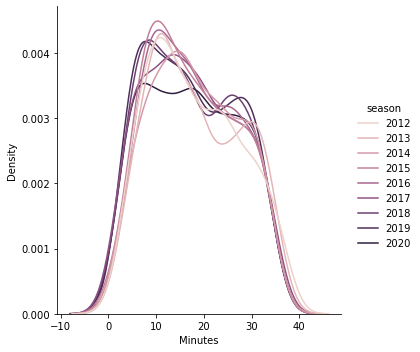

In [24]:
# Distribution of Minutes
sns.displot(data = stats, x = 'Minutes', hue = 'season', kind = 'kde', alpha = 0.6)

In [25]:
stats.Minutes.describe()

count    5016.000000
mean       17.677163
std         9.269223
min         0.000000
25%         9.925595
50%        16.915780
75%        25.410592
max        38.130435
Name: Minutes, dtype: float64

In [26]:
# Top 20 players by PER
stats[['PLAYER_NAME','season', 'Minutes','PER']].groupby(['PLAYER_NAME']).mean('PER').sort_values('PER', ascending = False).head(20)

season   Minutes        PER
PLAYER_NAME                                      
Taylor Braun     2017.000000  0.000000        inf
Zhou Qi          2017.500000  2.305556        inf
Levi Randolph    2017.666667  8.444444        inf
Daniel Dixon     2017.000000  0.000000        inf
Christ Koumadje  2019.000000  3.000000  98.742772
Eric Mika        2019.000000  3.000000  95.493852
Kahlil Whitney   2020.000000  1.000000  94.445565
Kaiser Gates     2018.500000  4.250000  90.483834
Derek Willis     2017.000000  2.000000  78.301131
Stephen Holt     2014.000000  2.000000  73.305112
Melo Trimble     2017.000000  2.000000  72.153135
Jeremy Senglin   2017.000000  5.000000  66.745735
Johnny Hamilton  2018.000000  5.000000  65.144800
J.J. Avila       2016.000000  2.000000  58.757780
Javin DeLaurier  2020.000000  3.000000  58.598790
Myck Kabongo     2013.000000  5.000000  54.550799
Jahlil Tripp     2020.000000  3.000000  52.085517
Walker Russell   2012.000000  6.000000  47.304710
Tyler Cook       2019.500000  2.961538  47.231012
V.J. Beachem     2017.000000  3.000000  46.349435

In [27]:
#stats.groupby('PLAYER_NAME').describe()

In [28]:
#sns.pairplot(data = stats, kind = 'kde', dropna = True)

# Methods

In [29]:
df

PLAYER_ID  season        PLAYER_NAME TEAM_ABBREVIATION     TEAM_ID  \
0            255    2012         Grant Hill               LAC  1610612746   
1            467    2012         Jason Kidd               NYK  1610612752   
2            703    2012        Kurt Thomas               NYK  1610612752   
3            708    2012      Kevin Garnett               BOS  1610612738   
4            708    2013      Kevin Garnett               BKN  1610612751   
...          ...     ...                ...               ...         ...   
5011     1630270    2020       Xavier Sneed               CHA  1610612766   
5012     1630271    2020     Brodric Thomas               HOU  1610612745   
5013     1630273    2020  Freddie Gillespie               DAL  1610612742   
5014     1630278    2020         Ade Murkey               MIN  1610612750   
5015  1962937827    2017          Matt Matt               SAC  1610612758   

      GP_x    Minutes       FGM        FGA      FG3M  ...  Jersey  2KRank  \
0       12  15.500000  1.992754   4.800725  0.090580  ...       0    88.0   
1       43  27.674419  2.679474   6.597573  1.971689  ...       0    54.0   
2       33  10.121212  1.119895   2.272727  0.000000  ...       0   299.0   
3       49  28.959184  6.499556  12.843833  0.000000  ...       0    28.0   
4       43  20.372093  3.071055   7.306140  0.000000  ...       1    29.0   
...    ...        ...       ...        ...       ...  ...     ...     ...   
5011     3   5.666667  0.672043   1.680108  0.672043  ...       0   500.0   
5012     7   6.857143  0.720046   2.448157  0.288018  ...       0   500.0   
5013     1   5.000000  1.008065   2.016129  0.000000  ...       0   500.0   
5014     1   3.000000  0.000000   1.008065  0.000000  ...       0   500.0   
5015     1   0.000000  0.000000   0.000000  0.000000  ...       0   500.0   

      LastASG?  PriorASG  Selected?  Starting_Position   pace  CONFERENCE  \
0            0         7          0               None  0.920        West   
1            0        10          0                  G  0.920        East   
2            0         0          0                  F  0.920        East   
3            0        14          1                  C  0.920        East   
4            1        15          0                  F  0.939        East   
...        ...       ...        ...                ...    ...         ...   
5011         0         0          0               None  0.992        East   
5012         0         0          0               None  0.992        West   
5013         0         0          0               None  0.992        West   
5014         0         0          0               None  0.992        West   
5015         0         0          0               None  0.973        West   

      GP_y    GP_Per  
0       55  0.218182  
1       49  0.877551  
2       49  0.673469  
3       51  0.960784  
4       51  0.843137  
...    ...       ...  
5011    24  0.125000  
5012    22  0.318182  
5013    23  0.043478  
5014    22  0.045455  
5015    56  0.017857  

[5016 rows x 35 columns]

In [30]:
# replace nan with 0
df.fillna(0, inplace = True)

In [31]:
# Create a list with numeric importatn stats
xcols = df.columns[6 : 29].to_list()

print(xcols)

['Minutes', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'PER', 'TSP', 'W_PCT', 'Jersey', '2KRank', 'LastASG?', 'PriorASG']


In [32]:
# set train and test up
X_train, X_test, y_train, y_test = train_test_split(df[xcols], df['Selected?'], 
                                                    train_size = 0.8, random_state = 1)
print('training data:', X_train.shape)
print('test data:', X_test.shape)


training data: (4012, 23)
test data: (1004, 23)


In [33]:
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

In [34]:
# logistic regression
# even without solver specified, same results are shown
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 3000)

# Fit the model to the training data
clf = log_reg.fit(X_train, y_train)

# Get accuracy stats
print('training accuracy: {}'.format(clf.score(X_train, y_train).round(3)))
print('test accuracy: {}'.format(clf.score(X_test, y_test).round(3)))

training accuracy: 0.982
test accuracy: 0.985


In [35]:
# Put the coefficients into a new dataframe
coef = pd.concat([pd.DataFrame(xcols),
                  pd.DataFrame(np.transpose(clf.coef_))], 
                 axis = 1)

coef.columns = ['feature','coefficient']

coef.sort_values(by=['coefficient'], 
                 ascending = False, 
                 inplace = True)

# Examine the features/stats with the 10 largest positive and negative coefficients
print('Ten largest positive features:\n', coef.head(10), '\n')
print('Ten largest negative features:\n', coef.tail(10))


Ten largest positive features:
      feature  coefficient
18     W_PCT     1.843406
11       BLK     0.712372
14       PTS     0.675043
21  LastASG?     0.467123
19    Jersey     0.402801
9        AST     0.389626
10       STL     0.357567
8       DREB     0.324485
7       OREB     0.292287
3       FG3M     0.210574 

Ten largest negative features:
     feature  coefficient
0   Minutes     0.146525
5       FTM     0.134939
17      TSP     0.118157
20   2KRank    -0.010577
12       TO    -0.044405
6       FTA    -0.139203
16      PER    -0.142049
4      FG3A    -0.146052
2       FGA    -0.378403
13       PF    -0.505643


In [36]:
# Adding the features with the 10 largest positive and negative coefficients 
# to a new list for training purposes

xcols2 = coef.feature[0:10].to_list()
xcols2 += coef.feature[-10:].to_list()
print(xcols2)

['W_PCT', 'BLK', 'PTS', 'LastASG?', 'Jersey', 'AST', 'STL', 'DREB', 'OREB', 'FG3M', 'Minutes', 'FTM', 'TSP', '2KRank', 'TO', 'FTA', 'PER', 'FG3A', 'FGA', 'PF']


In [37]:
# test train fpr large coefficients
X_train, X_test, y_train, y_test = train_test_split(df[xcols2], 
                                                    df['Selected?'], 
                                                    train_size = 0.8, 
                                                    random_state = 1)
print('training data:', X_train.shape)
print('test data:', X_test.shape)

# fit the model to the training data
clf2 = log_reg.fit(X_train, y_train)

# get accuracy stats
print('training accuracy: {}'.format(clf2.score(X_train, y_train).round(3)))
print('test accuracy: {}'.format(clf2.score(X_test, y_test).round(3)))

training data: (4012, 20)
test data: (1004, 20)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Regularization with logistic regression & C parameter with logistic regression

# high C value means trust the data a lot; low means ehhh
cset = [.001, .01, .1, 1, 10]

for i in cset:
    print('C =', i)
    log_reg = LogisticRegression(solver = 'lbfgs', 
                                 max_iter = 3000, 
                                 C = i)
    
    clf = log_reg.fit(X_train, y_train)
    
    print('training accuracy: {}'.format(clf.score(X_train, y_train).round(3)))
    print('test accuracy: {}'.format(clf.score(X_test, y_test).round(3)), '\n')

In [ ]:
# Cross-validation with tuning regularization in logistic regression

for i in cset:
    print('C =', i)
    log_reg = LogisticRegression(solver = 'lbfgs', 
                                 max_iter = 3000, 
                                 C = i)
    
    scores = cross_val_score(log_reg, 
                             df[xcols2], 
                             df['Selected?'], 
                             cv = 5)
    print(scores)
    print('Accuracy: %0.3f (+/- %0.3f)' % (scores.mean(), scores.std() * 2), '\n')

In [ ]:

y_pred_test = clf.predict(X_test)
print('  Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))
print('  Precision: {:.3f}'.format(precision_score(y_test, y_pred_test)))
print('  F1 score: {:.3f}'.format(f1_score(y_test, y_pred_test)))
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('  Specificity: {:.3f}'.format(specificity))

In [ ]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_test)
sample = np.array([['TN', 'FP'], ['FN', 'TP']])
print('CM key:\n', sample, '\n')
print('CM for test:\n', cm)

In [ ]:
scaler = MinMaxScaler()

X = df[xcols2]
scaled_X = scaler.fit_transform(X)
y = df['Selected?']

In [ ]:

scaled_X = scaler.fit_transform(X_train)

tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}

grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                    cv = 3, scoring = 'accuracy')

grid.fit(scaled_X, y_train)

print('mean of accuracies:', grid.cv_results_['mean_test_score'])
print('std dev of accuracies:', grid.cv_results_['std_test_score'])

# print best parameter after tuning 
print('best parameters:', grid.best_params_) 

# store the best estimator (In this case it's 'C': 100)
best_logreg = grid.best_estimator_

In [ ]:
# Random forest
param_grid = {'n_estimators': [10, 100, 250], 'max_samples': [.25, .5, 1]} 


# instantiate grid search object
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3)

# fitting the model for grid search 
grid.fit(X, y)

# print parameters, mean, and standard deviation of scores by iteration
for z in range(0, len(grid.cv_results_['params'])):
    print('\nparams:', grid.cv_results_['params'][z])
    print('mean of accuracies:', grid.cv_results_['mean_test_score'][z])
    print('std dev of accuracies:', grid.cv_results_['std_test_score'][z])

# print best parameter after tuning 
print('\n***best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

# store the best estimator (in this case it's 'max_samples': 0.5, 'n_estimators': 100)
best_rf = grid.best_estimator_

In [ ]:
mydata = grouped[(grouped['season'] == 2020)]
mydata = mydata.drop('Selected?', axis=1, errors='coerce')
mydata

In [ ]:
mydata.fillna(0, inplace = True)
mydata.replace([np.inf, -np.inf], np.nan, inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

In [ ]:
print(xcols)

In [ ]:
# time to predict
pred = clf.predict(mydata[xcols2])
print(pred)

In [ ]:
# add predictions to df
mydata['All-Star'] = pred.tolist()
print(mydata)

In [ ]:
# see the predictions
mydata.loc[mydata['All-Star'] == 1]

Predicted 33 all stars. There were 24 in real life. Is there a way to limit to 24 in the model?

**Starters:**
LeBron James, Anthony Davis, Kawhi Leonard, Luka Doncic, James Harden,
Giannis Antetokounmpo, Joel Embiid, Pascal Siakam, Kemba Walker, Trae Young

**Reserves:**
Damian Lillard, Ben Simmons, Nikola Jokic, Jayson Tatum, Chris Paul, Russell Westbrook, Domantas Sabonis, Khris Middleton, Bam Adebayo, Rudy Gobert, Kyle Lowry, Brandon Ingram, Donovan Mitchell

**Starters that were left out:** Pascal Siakam, Kemba Walker

**Reserves that were left out:** Chris Paul, Kyle Lowry

**MODEL SHOWS 83% ACCURACY OVERALL**